<a href="https://colab.research.google.com/github/fungazi27/NLP/blob/main/recommend_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

url = "https://raw.githubusercontent.com/fungazi27/NLP/refs/heads/main/simplified_coffee.csv"
df = pd.read_csv(url)

In [ ]:
df.head()

,name,roaster,roast,loc_country,origin,100g_USD,rating,review_date,review
0,Ethiopia Shakiso Mormora,Revel Coffee,Medium-Light,United States,Ethiopia,4.70,92,November 2017,"Crisply sweet, cocoa-toned. Lemon blossom, roa..."
1,Ethiopia Suke Quto,Roast House,Medium-Light,United States,Ethiopia,4.19,92,November 2017,"Delicate, sweetly spice-toned. Pink peppercorn..."
2,Ethiopia Gedeb Halo Beriti,Big Creek Coffee Roasters,Medium,United States,Ethiopia,4.85,94,November 2017,"Deeply sweet, subtly pungent. Honey, pear, tan..."
3,Ethiopia Kayon Mountain,Red Rooster Coffee Roaster,Light,United States,Ethiopia,5.14,93,November 2017,"Delicate, richly and sweetly tart. Dried hibis..."
4,Ethiopia Gelgelu Natural Organic,Willoughby's Coffee & Tea,Medium-Light,United States,Ethiopia,3.97,93,November 2017,"High-toned, floral. Dried apricot, magnolia, a..."


In [ ]:
df['review'] = df['review'].fillna('')
df['review'].head()

0    Crisply sweet, cocoa-toned. Lemon blossom, roa...
1    Delicate, sweetly spice-toned. Pink peppercorn...
2    Deeply sweet, subtly pungent. Honey, pear, tan...
3    Delicate, richly and sweetly tart. Dried hibis...
4    High-toned, floral. Dried apricot, magnolia, a...
Name: review, dtype: object

In [ ]:
# Import necessary libraries for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
# Download necessary NLTK data files (only need to run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [ ]:
df['tokenized_review'] = df['review'].astype(str)

df['tokenized_review'] = df['tokenized_review'].apply(preprocess_text)

df['tokenized_review'].head()

0    [crisply, sweet, lemon, blossom, roasted, caca...
1    [delicate, sweetly, pink, peppercorn, date, my...
2    [deeply, sweet, subtly, pungent, honey, pear, ...
3    [delicate, richly, sweetly, tart, dried, hibis...
4    [floral, dried, apricot, magnolia, almond, but...
Name: tokenized_review, dtype: object

In [ ]:
model = Word2Vec(sentences=df['tokenized_review'], vector_size=100, window=5, min_count=1, workers=4)
print(f'Vocab size: {len(model.wv.index_to_key)}')

Vocab size: 1030


In [ ]:
words = model.wv.index_to_key[:10]

word_embeddings = [model.wv[word] for word in words]
embeddings_df = pd.DataFrame(word_embeddings, index=words)

print(embeddings_df)

                 0         1         2         3         4         5   \
cup       -0.124066  0.343009  0.163544  0.378252  0.186508 -0.537913   
aroma     -0.124251  0.329232  0.171044  0.362466  0.197941 -0.527462   
finish    -0.158716  0.372020  0.130278  0.341752  0.279460 -0.489300   
mouthfeel -0.191672  0.387622  0.149840  0.332419  0.272711 -0.478792   
structure -0.148422  0.324410  0.142565  0.323289  0.212690 -0.465323   
acidity   -0.189029  0.347665  0.142073  0.302397  0.219239 -0.436900   
chocolate -0.001963  0.327012  0.127657  0.438112  0.210155 -0.696339   
sweet     -0.029814  0.314035  0.152003  0.409476  0.188919 -0.632328   
note      -0.125452  0.386216  0.139561  0.402429  0.285635 -0.591503   
richly    -0.008617  0.297540  0.124905  0.407690  0.181718 -0.660604   

                 6         7         8         9   ...        90        91  \
cup        0.184595  0.774228 -0.414017 -0.390280  ...  0.538668  0.166871   
aroma      0.173645  0.723544 -0.382016 

In [ ]:
def get_coffee_embeddings(tokenized_text, model, embedding_size=100):
    valid_embeddings = [model.wv[word] for word in tokenized_text if word in model.wv]

    if len(valid_embeddings) == 0:
        return np.zeros(embedding_size)

    return np.mean(valid_embeddings, axis=0)

embedding_size = model.vector_size
df['coffee_embeddings'] = df['tokenized_review'].apply(lambda x: get_coffee_embeddings(x, model, embedding_size=embedding_size))

In [ ]:
invalid_embeddings = df['coffee_embeddings'].apply(lambda x: x.shape[0] != embedding_size or np.any(np.isnan(x)))

print(f'Number of invalid embedding: {invalid_embeddings.sum()}')

df = df[~invalid_embeddings]

Number of invalid embedding: 0


In [ ]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

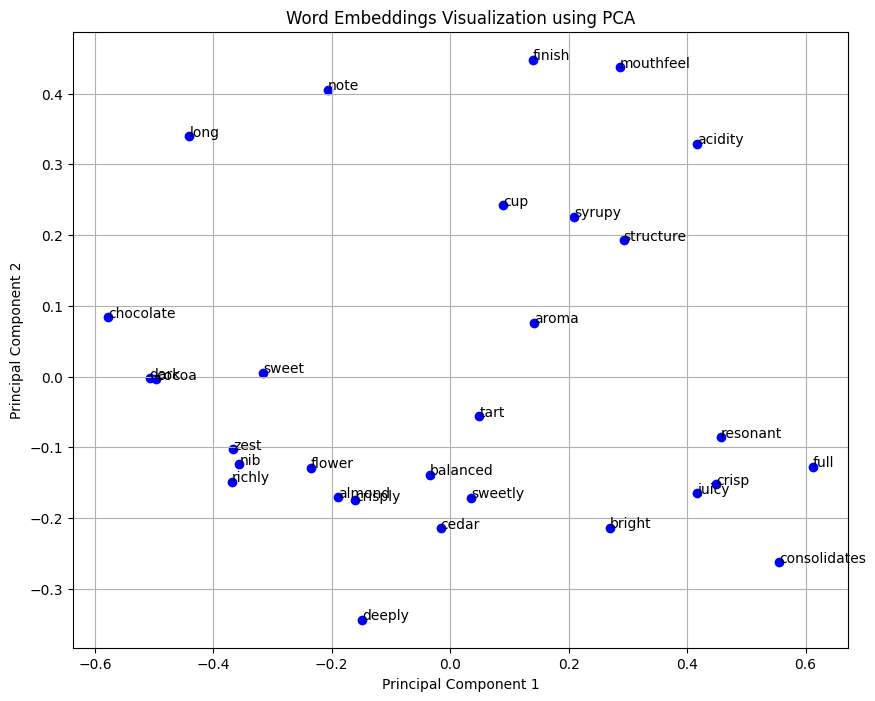

In [ ]:
words = list(model.wv.index_to_key)[:30]

word_vectors = [model.wv[word] for word in words]

pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], c='blue')

for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

plt.title('Word Embeddings Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

In [ ]:
embeddings_matrix = np.vstack(df['coffee_embeddings'].values)
cosine_sim = cosine_similarity(embeddings_matrix)

cosine_sim_df = pd.DataFrame(cosine_sim, index=df['roaster'], columns=df['roaster'])

cosine_sim_df_subset = cosine_sim_df.iloc[:30, :30]
cosine_sim_df_subset.head()

roaster,Revel Coffee,Roast House,Big Creek Coffee Roasters,Red Rooster Coffee Roaster,Willoughby's Coffee & Tea,Black Oak Coffee Roasters,Wonderstate Coffee,Reunion Island Coffee,Old Soul Co.,A.R.C.,...,Noble Coffee Roasting,Ben's Beans,Espresso Republic,Roast House,Good Folks Coffee,Flight Coffee Co.,Green Stone Coffee,Willoughby's Coffee & Tea,Equator Coffees & Teas,Hula Daddy Kona Coffee
roaster,,,,,,,,,,,,,,,,,,,,,
Revel Coffee,1.000000,0.999481,0.999905,0.999856,0.999848,0.999923,0.999859,0.999910,0.999923,0.999805,...,0.999848,0.999508,0.999909,0.999928,0.999915,0.999572,0.999109,0.999789,0.999609,0.999587
Roast House,0.999481,1.000000,0.999729,0.999808,0.999816,0.999692,0.999818,0.999740,0.999589,0.999868,...,0.999832,0.999908,0.999476,0.999271,0.999613,0.999929,0.999875,0.999881,0.999868,0.999905
Big Creek Coffee Roasters,0.999905,0.999729,1.000000,0.999946,0.999946,0.999943,0.999899,0.999928,0.999897,0.999940,...,0.999943,0.999790,0.999921,0.999834,0.999963,0.999822,0.999519,0.999933,0.999855,0.999768
Red Rooster Coffee Roaster,0.999856,0.999808,0.999946,1.000000,0.999938,0.999941,0.999943,0.999927,0.999907,0.999932,...,0.999963,0.999825,0.999842,0.999765,0.999879,0.999832,0.999581,0.999956,0.999861,0.999863
Willoughby's Coffee & Tea,0.999848,0.999816,0.999946,0.999938,1.000000,0.999932,0.999937,0.999911,0.999859,0.999953,...,0.999959,0.999861,0.999866,0.999756,0.999908,0.999883,0.999640,0.999931,0.999892,0.999853


In [ ]:
coffee_indices = pd.Series(df.index, index=df['roaster']).drop_duplicates()

def recommend_coffee(roaster, cosine_sim=cosine_sim, df=df, coffee_indices=coffee_indices):
    idx = coffee_indices[roaster]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:11]

    coffee_indices = [i[0] for i in sim_scores]

    return df['roaster'].iloc[coffee_indices]

In [ ]:
recommendations = recommend_coffee('Roast House')
print(recommendations)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
'''
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
'''

In [ ]:
#mlb = MultiLabelBinarizer()
#binary_matrix = mlb.fit_transform(df['tokenized_review'])

In [ ]:
#jacard_sim = np.zeros((binary_matrix.shape[0], binary_matrix.shape[0]))

In [ ]:
'''
for i in range(binary_matrix.shape[0]):
    for j in range (binary_matrix.shape[0]):
        jacard_sim[i][j] = jaccard_score(binary_matrix[i], binary_matrix[j])
'''

In [ ]:
#jaccard_sim_df = pd.DataFrame(jaccard_sim, index=df['roaster'], columns=df['roaster'])

In [ ]:
#jaccard_sim_df_subset = jaccard_sim_df.iloc[:30, :30]

In [ ]:
#import ace_tools as tools